# Estimation

This page estimates the model parameters. We will do this in two steps:
1. [Using a grid of parameters values](grid)
2. [Using a Optimizer](opt)

```{warning} 
Remember that `dhr.func` is the sintax that calls the file with the functions see before.
```

## Packages

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import dhr_functions as dhr
from scipy.optimize import minimize
from matplotlib import pyplot as plt

## Calling the simulated data for the treatment

First we will call our simulated data using the function and transform in a dictionary. The dictionary makes 
the estimation faster. The dataframe_simulation function creates two dataset (control and treatment) and put them 
in a dictionary to return. `dataset` is going to store this dictionary.

In [2]:
dataset = dhr.dataframe_simulation()
dataset['treatment']

,id,t,d+1,d,L,eps,U
0,0,1,1.0,0.0,0.0,-0.572858,50.736634
1,0,2,2.0,1.0,0.0,0.154607,50.538425
2,0,3,2.0,2.0,1.0,1.889621,51.730462
3,0,4,3.0,2.0,0.0,-0.613751,48.642785
4,0,5,4.0,3.0,0.0,-0.192819,48.444930
...,...,...,...,...,...,...,...
2995,99,26,18.0,17.0,0.0,0.194402,33.791186
2996,99,27,19.0,18.0,0.0,-1.103202,33.593390
2997,99,28,20.0,19.0,0.0,-0.675562,33.395593
2998,99,29,21.0,20.0,0.0,-1.585189,33.197797


Select the group you want and take it from the dictionary. We will use the treatment.

In [3]:
data = dataset['treatment'].to_dict('records')

## Example with initial values
Now, set the initial values for the estimation, the list is [beta, theta]. After determining this, call the 
model solution to extract the probabilities of working and leisure.

In [4]:
theta=[0.01,4.5]
probs_w, probs_l, _, _, _, _, = dhr.model_solution(beta = theta[0], mu = theta[1]);

Now we will calculate the Maximum Likelihood for a specific initial value. This will be repeated multiple times
in the estimation in order to find the minimu log likelihood value.

In [5]:
logL = 0
for i in range(len(data)):
    t = int(data[i]['t'])
    d = int(data[i]['d'])
    L = int(data[i]['L'])
    likelihood = np.log(probs_w[t-1,d])*(1-L)+ np.log(probs_l[t-1,d])*L
    logL = logL + likelihood 

Now, check the value

In [6]:
-logL

4619.478266596326

Our estimation wants to minimize this, in order to match the model solution and the simulated data. Let's see this in two ways:
- Using a grid of parametes values
- Optmizer

(grid)=

## Grid of values

We will create a grid of values for beta and mu. After that, we will compute the Likelihood of the combinations and pick
the combination that generates the lowest value.

In [7]:
n = 10
b_guess  = np.linspace(0.01, 0.04,n)
mu_guess = np.linspace(3, 4.5,n)

Above I create a grid with 10 values each for beta and mu. Let's compute the Likelihoods. I will use a function called
Log_likelihood(), wich computes and stores parameters combinations and repective likelihood values in a dataframe.

In [8]:
start = time.perf_counter()
log_values = dhr.Log_likelihood(data, b_guess, mu_guess)
maxL = log_values['likelihood'].max()
optb = round(log_values.loc[ log_values['likelihood'] == maxL]['beta'].item(),2)
optmu = round(log_values.loc[ log_values['likelihood'] == maxL]['mu'].item(),2)
end = time.perf_counter()

Let's see the result

In [9]:
print('optimun beta:' + str(optb) +'\noptimun mu:' + str(optmu))
print("Elapsed (with compilation) = {}s".format((end - start)))

optimun beta:0.03
optimun mu:4.0
Elapsed (with compilation) = 10.396148917000001s


The result is exaclty the parameters estimated in the model. Now, lets plot this and see graphically.

In [10]:
# PLOTTING SETTINGS
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500
sns.set_style('ticks')
sns.despine(left=False, bottom=True)
sns.set_context("paper")

<Figure size 3200x2400 with 0 Axes>

Above I just defined settings to improve plotting quality

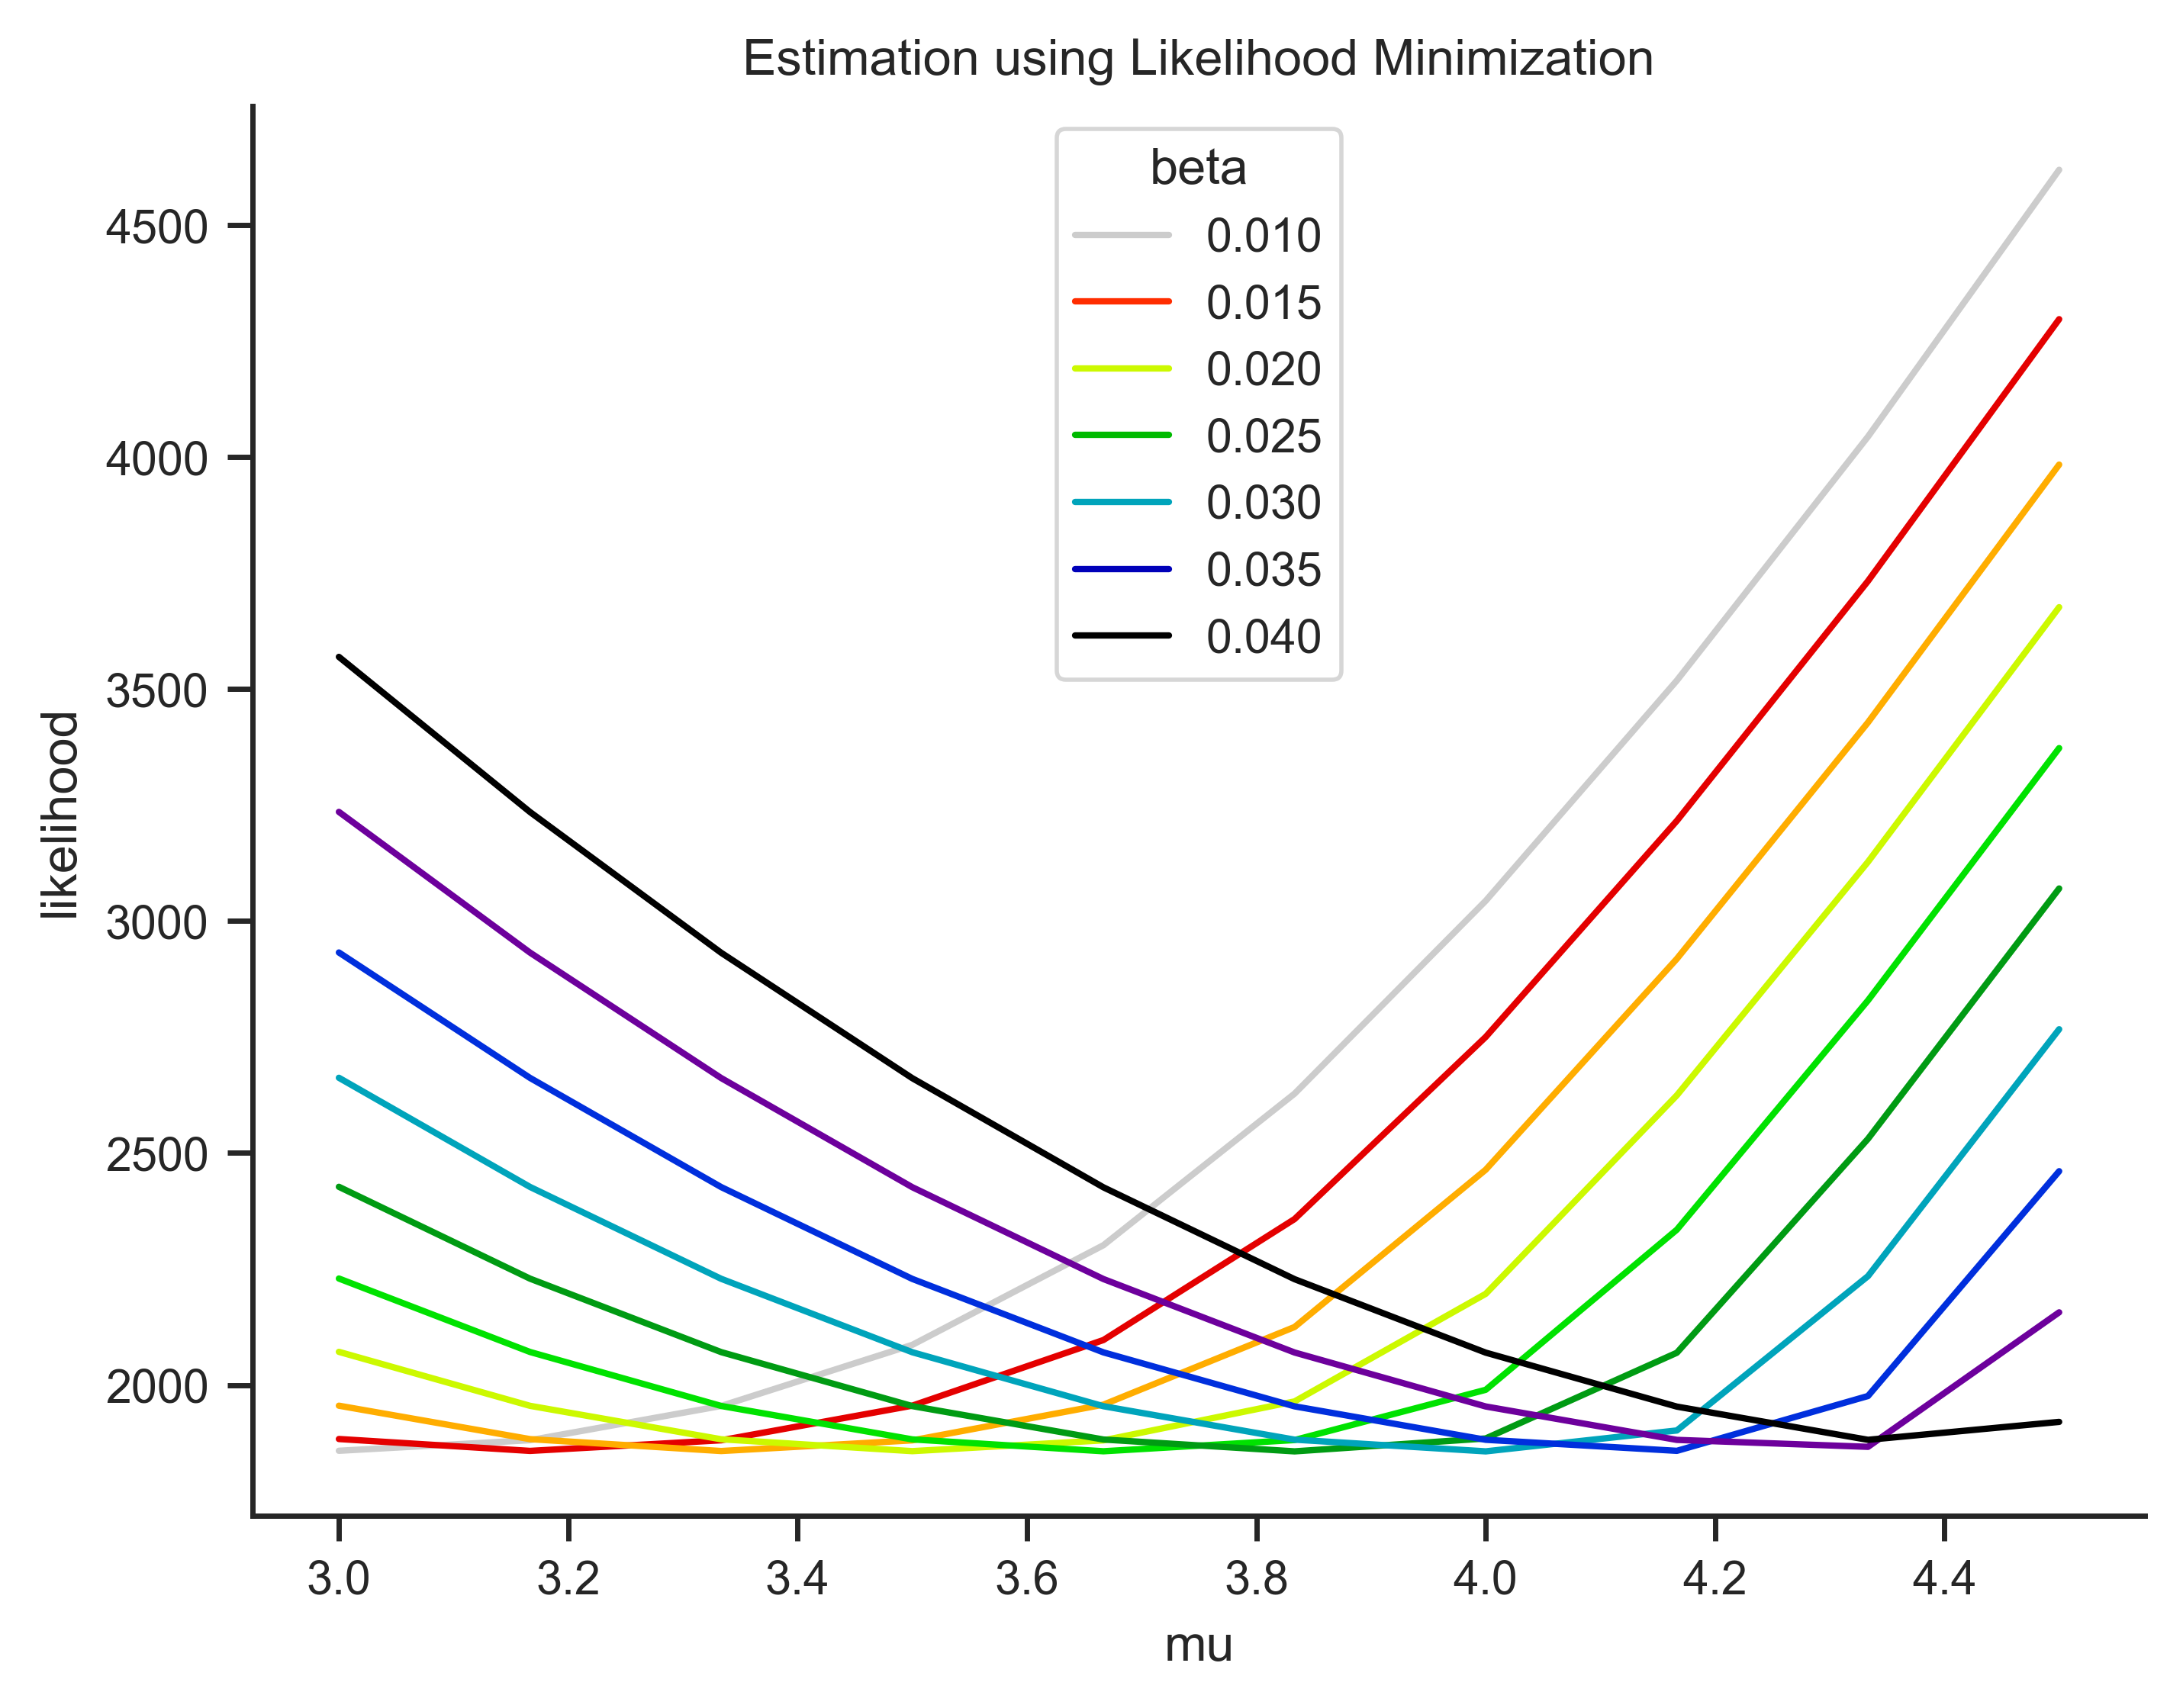

In [11]:
sns.lineplot(data = log_values, x = 'mu', y = (log_values['likelihood']*-1), hue = 'beta', palette= 'nipy_spectral_r' ).set(title = 'Estimation using Likelihood Minimization')    
sns.despine(left=False, bottom=False)

(opt)=

## Optimizer

Now, use a minimizer (here `minimize` from scipy package) to find the parameters values that minimizes the log likelihood.
We need to define the function used to estimate the logLikelihood and put this as an argument of the function (`opt_likelihood`).
Also, we need to choose the initial guess and method.

In [12]:
def opt_likelihood(theta):
    probs_w, probs_l, _, _, _, _, = dhr.model_solution(beta = theta[0], mu = theta[1]);
    logL = 0
    for i in range(len(data)):
        t = int(data[i]['t'])
        d = int(data[i]['d'])
        L = int(data[i]['L'])
        likelihood = np.log(probs_w[t-1,d])*(1-L)+ np.log(probs_l[t-1,d])*L
        logL = logL + likelihood 
    return -logL

start = time.perf_counter()
resu = minimize(opt_likelihood, theta, method = "SLSQP" )
end = time.perf_counter()

/Users/angelosantos/Documents/GitHub/human-capital/websites/hc_routines/myst/dhr/dhr_functions.py:151: RuntimeWarning: invalid value encountered in double_scalars
  e_exp = eps_mean + (eps_sd*norm.pdf((eps_thres-eps_mean)/eps_sd)/(1-norm.cdf((eps_thres-eps_mean)/eps_sd)));
/var/folders/sb/z5dkqpwn7pzchsbq06rbbm9w0000gn/T/ipykernel_16298/2744515528.py:8: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(probs_w[t-1,d])*(1-L)+ np.log(probs_l[t-1,d])*L
/var/folders/sb/z5dkqpwn7pzchsbq06rbbm9w0000gn/T/ipykernel_16298/2744515528.py:8: RuntimeWarning: invalid value encountered in double_scalars
  likelihood = np.log(probs_w[t-1,d])*(1-L)+ np.log(probs_l[t-1,d])*L
/Users/angelosantos/Documents/GitHub/human-capital/websites/hc_routines/myst/dhr/dhr_functions.py:151: RuntimeWarning: divide by zero encountered in double_scalars
  e_exp = eps_mean + (eps_sd*norm.pdf((eps_thres-eps_mean)/eps_sd)/(1-norm.cdf((eps_thres-eps_mean)/eps_sd)));
/Users/angelosantos/Documents/GitHub/

Now, print the results and see that the values that minimize the function are close to beta = 0.03 and mu = 4, the estimated
values from the paper.

In [13]:
print('Optimun beta:' + str(round(resu.x[0],2)) + "\n" + 'Optimun mu:' + str(round(resu.x[1],2)))
print("Elapsed (with compilation) = {}s".format((end - start)))

Optimun beta:0.03
Optimun mu:3.93
Elapsed (with compilation) = 5.028053667s
